### Random Walk while inserting the coordinates/movement direction to the CNN and RNN
Here I will try to insert the direction of the path taken to the networks. 
<br> So... if our Syclop move in the following trajectory: [x,y]
<br> [36, 36],
<br>        [33, 37],
<br>        [34, 39],
<br>[35, 39],
<br>       [36, 40])
<br> I will concatinate the [x,y] values to the network state after the CNN network and before the RNN or FC networks. 
<br> We can also insert the destination and the source - [x_t,y_t],[x_t-1, y_t-1]


In [1]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle

In [2]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/labs/ahissarlab/orra/imagewalker/misc.py'>

In [118]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

mnist = MNIST('/home/labs/ahissarlab/orra/datasets/mnist')
images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc

#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

### Show an example of Syclop path and outputs:

In [48]:
img=misc.build_mnist_padded(1./256*np.reshape(images[45],[1,28,28]))

In [49]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [41]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[36, 36],
       [33, 37],
       [34, 39],
       [35, 39],
       [36, 40]])

In [50]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


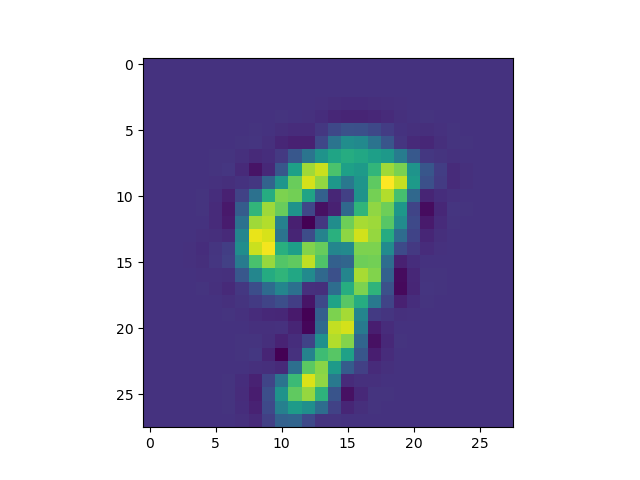

<IPython.core.display.Javascript object>


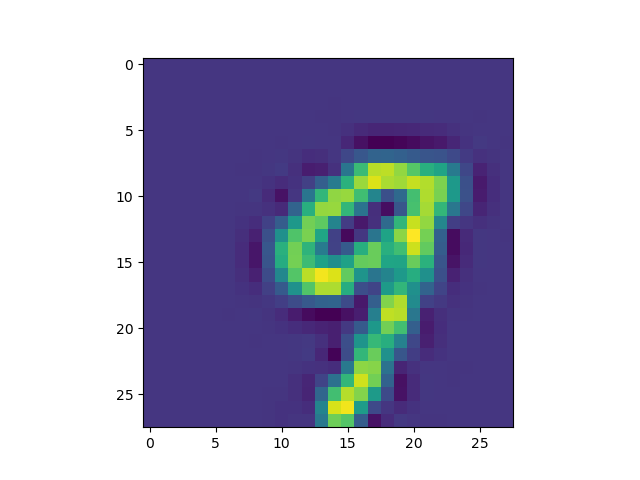

<IPython.core.display.Javascript object>


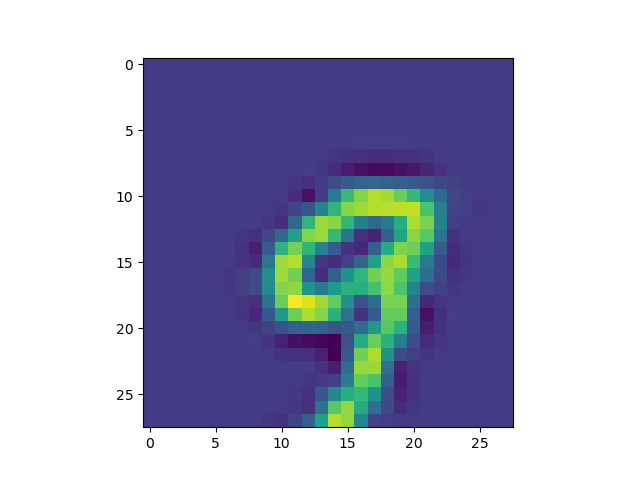

<IPython.core.display.Javascript object>


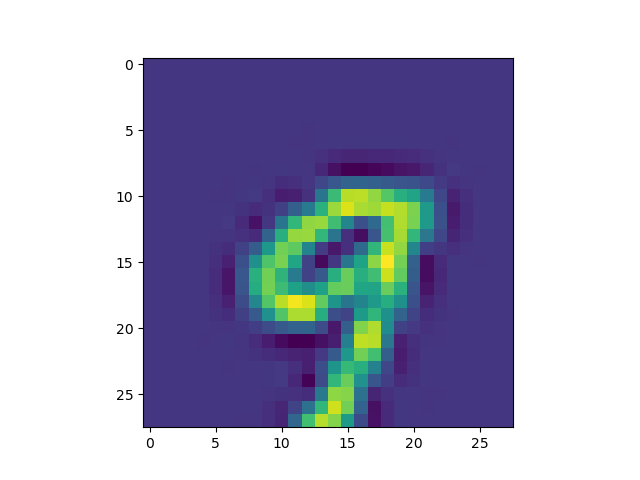

<IPython.core.display.Javascript object>


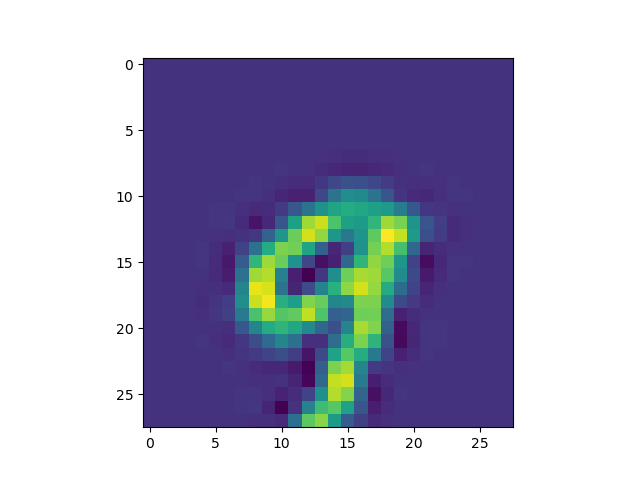

In [51]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [119]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, add_traject = True):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.

    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    q_seq = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img in images:
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
        
        steps  = []
        for j in range(5):
            steps.append(starting_point*1)
            starting_point += np.random.randint(-5,5,2) 
        
        if mixed_state:
            q_sequence = np.array(steps).astype(int)
        else:
            if count == 0:
                q_sequence = np.array(steps).astype(int)
        
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            plt.title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        q_seq.append(q_sequence)
        count += 1
        

    
    if add_traject: #If we add the trjectories the train list will become a list of lists, the images and the 
        #corrosponding trajectories, we will change the dataset structure as well. Note the the labels stay the same.
        ts_train = [ts_images[:55_000], q_seq[:55_000]] 
        train_labels = labels[:55_000]
        ts_val = [ts_images[55_000:], q_seq[55_000:]]
        val_labels = labels[55_000:]

    else:
        ts_train = ts_images[:55_000]
        train_labels = labels[:55_000]
        ts_val = ts_images[55_000:]
        val_labels = labels[55_000:]

    dvs_train = dvs_images[:55_000]
    dvs_val = dvs_images[55_000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, add_traject = False, transform = None):

            self.data = data
            self.labels = labels

            self.add_traject = add_traject
            self.transform = transform
        def __len__(self):
            if self.add_traject: 
                return len(self.data[0]) 
            else: return len(self.data[0])


        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            if self.add_traject:
                img_data = self.data[0][idx] 
                traject_data = self.data[1][idx]
                label = self.labels[idx]
                return img_data, traject_data, label
            else:
                data = self.data[idx]



            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels
        
    train_dataset = mnist_dataset(ts_train, train_labels,add_traject = True)
    test_dataset = mnist_dataset(ts_val, val_labels,add_traject = True)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    
    return train_dataloader, test_dataloader, ts_train, train_labels

In [99]:
len(ts_train[1])
class mnist_dataset(Dataset):
    def __init__(self, data, labels, add_traject = False, transform = None):

        self.data = data
        self.labels = labels
        
        self.add_traject = add_traject
        self.transform = transform
    def __len__(self):
        if self.add_traject: 
            return len(self.data[0]) 
        else: return len(self.data[0])
        

    def __getitem__(self, idx):
        '''
        args idx (int) :  index

        returns: tuple(data, label)
        '''
        if self.add_traject:
            img_data = self.data[0][idx] 
            traject_data = self.data[1][idx]
            label = self.labels[idx]
            return img_data, traject_data, label
        else:
            data = self.data[idx]

        

        if self.transform:
            data = self.transform(data)
            return data, label
        else:
            return data, label

    def dataset(self):
        return self.data
    def labels(self):
        return self.labels
train_dataset = mnist_dataset(ts_train, train_labels, add_traject = True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [115]:
len(train_dataset[:][2])


64

In [121]:
for batch_idx, (img, traject, targets) in enumerate(train_dataloader):
    print(img.shape, traject.shape, targets.shape)
    break
print(data[0], len(data[1]), data[1][0].shape, data[1][1].shape, data[1][2].shape)
data[1][1][1], data[0]

torch.Size([64, 5, 28, 28]) torch.Size([64, 5, 2]) torch.Size([64])
0 3 torch.Size([64, 5, 28, 28]) torch.Size([64, 5, 2]) torch.Size([64])


(tensor([[36, 36],
         [31, 31],
         [30, 26],
         [25, 27],
         [25, 25]]),
 0)

<IPython.core.display.Javascript object>


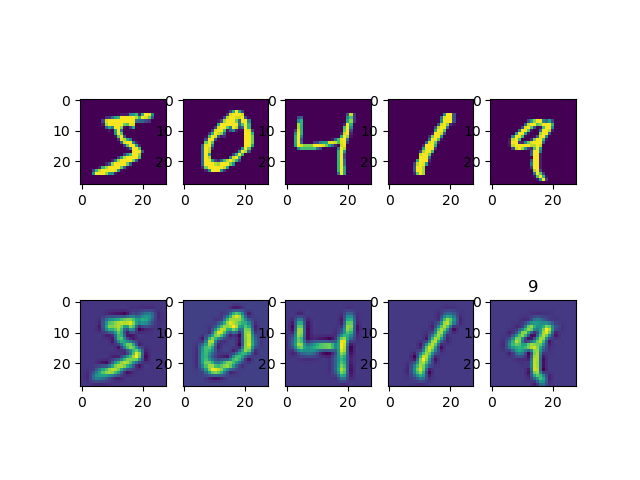

In [120]:
train_dataloader, test_dataloader, ts_train, train_labels = create_dataset(images, labels,res = 28)

torch.Size([2, 5, 28, 28])


1

In [137]:
class CNN(nn.Module):
    def __init__(self, traject = False):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.traject = traject
        if traject:
            self.fc1 = nn.Linear(8*8*16 + 10,64)
        else:
            self.fc1 = nn.Linear(8*8*16 ,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img, traject = None):
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        if traject is not None: 
            traject = traject.view(traject.shape[0], 10)
            img = torch.cat((img, traject),1) #Concatinate the trajectory to the flatten output 
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

class CNN_one_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img, traject):
        img = img[:,0,:,:]
        img = img.unsqueeze(1)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [149]:
class RNN_Net(nn.Module):
    def __init__(self, traject = False):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        if traject:
            self.gru = nn.GRU(8*8*16 + 2,100)
        else:
            self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data, traject = None):
        hn = torch.zeros([1,data.shape[0],100]).double().to('cuda')
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            if traject is not None:
                traject_i = traject[:,i,:]
                img = torch.cat((img, traject_i),1) #Concatenate the trajectory to the flatten output 
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

In [139]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()
    
    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data, traject, targets) in enumerate(train_dataloader):
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
                traject = traject.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            optimizer.zero_grad()
            output = net(data.double(), traject.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            
    
        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data, test_traject, test_targets) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                    test_traject = test_traject.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                test_output = net(test_data,test_traject)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
        
    return train_loss, test_loss, test_accur

In [141]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 4)

Net CNN_one_layer Epoch :  1 	 loss : 0.004429191832088137 accuracy : 98.35838
Net CNN_one_layer Epoch :  2 	 loss : 0.0009558422735431949 accuracy : 98.635284
Net CNN_one_layer Epoch :  3 	 loss : 0.19730037690265304 accuracy : 98.85285
Net CNN_one_layer Epoch :  4 	 loss : 0.08359671136097543 accuracy : 98.57595


In [142]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN(traject = True).double(), epochs = 4)

Net CNN Epoch :  1 	 loss : 0.0015413096034162326 accuracy : 97.80459
Net CNN Epoch :  2 	 loss : 0.003131342463717597 accuracy : 98.06171
Net CNN Epoch :  3 	 loss : 0.0027481074697087793 accuracy : 98.417725
Net CNN Epoch :  4 	 loss : 0.00042384479724387496 accuracy : 98.47706


### Regular conv net with regular data stacked works as well with more then 99% accuracy - let's push it into an RNN and see that we replecate the resilts before moving to lower resolutions. 

In [150]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 4)

Net RNN_Net Epoch :  1 	 loss : 0.5281256926428363 accuracy : 97.64636
Net RNN_Net Epoch :  2 	 loss : 0.010783229764544442 accuracy : 98.4375
Net RNN_Net Epoch :  3 	 loss : 0.004716106895197149 accuracy : 98.595726
Net RNN_Net Epoch :  4 	 loss : 0.09832791972563015 accuracy : 98.69462


### Mooving on to lower resolutions 

<IPython.core.display.Javascript object>


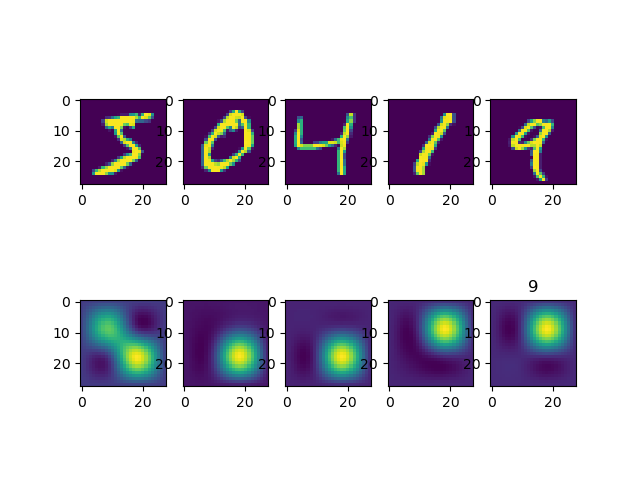

In [153]:
#Load the training data
train_dataloader, test_dataloader, _,_= create_dataset(images, labels,res = 6)

In [161]:
#Run the CNN over one image only
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 20)

Net CNN_one_layer Epoch :  1 	 loss : 1.1759106483404262 accuracy : 45.391613
Net CNN_one_layer Epoch :  2 	 loss : 1.1777610837687031 accuracy : 45.213608
Net CNN_one_layer Epoch :  3 	 loss : 1.4756517450826432 accuracy : 47.053005
Net CNN_one_layer Epoch :  4 	 loss : 1.2400543242438458 accuracy : 47.191456
Net CNN_one_layer Epoch :  5 	 loss : 1.336746715036983 accuracy : 47.290348
Net CNN_one_layer Epoch :  6 	 loss : 1.4256481077661787 accuracy : 47.329906
Net CNN_one_layer Epoch :  7 	 loss : 1.1703982449193953 accuracy : 47.01345
Net CNN_one_layer Epoch :  8 	 loss : 1.3839135633042845 accuracy : 47.36946
Net CNN_one_layer Epoch :  9 	 loss : 1.4603469025571236 accuracy : 47.646362
Net CNN_one_layer Epoch :  10 	 loss : 1.538667719666971 accuracy : 47.745255
Net CNN_one_layer Epoch :  11 	 loss : 1.4291459327893896 accuracy : 48.39794
Net CNN_one_layer Epoch :  12 	 loss : 1.0103620024503976 accuracy : 48.39794
Net CNN_one_layer Epoch :  13 	 loss : 1.0838964190092064 accuracy 

In [160]:
#Run the CNN over the stacked images
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN(traject = True).double(), epochs = 50)

Net CNN Epoch :  1 	 loss : 1.6198472964520325 accuracy : 45.114716
Net CNN Epoch :  2 	 loss : 2.398440248580278 accuracy : 47.54747
Net CNN Epoch :  3 	 loss : 1.7695395274342252 accuracy : 49.86155
Net CNN Epoch :  4 	 loss : 2.3051763763391118 accuracy : 51.04826
Net CNN Epoch :  5 	 loss : 0.9717062145857837 accuracy : 52.314083
Net CNN Epoch :  6 	 loss : 1.4810168703751978 accuracy : 51.839397
Net CNN Epoch :  7 	 loss : 0.7550077587462324 accuracy : 54.964397
Net CNN Epoch :  8 	 loss : 1.4075738539704021 accuracy : 53.303005
Net CNN Epoch :  9 	 loss : 1.618300641811167 accuracy : 53.322784
Net CNN Epoch :  10 	 loss : 1.5054545995114432 accuracy : 55.043514
Net CNN Epoch :  11 	 loss : 1.2292904112405176 accuracy : 54.80617
Net CNN Epoch :  12 	 loss : 1.9119855735889113 accuracy : 53.24367
Net CNN Epoch :  13 	 loss : 1.4151105786380525 accuracy : 54.6875
Net CNN Epoch :  14 	 loss : 1.6843677800292929 accuracy : 54.331486
Net CNN Epoch :  15 	 loss : 1.0352152589032417 accu

In [159]:
#Run the CNN+RNN over the stacked images
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 50)

Net RNN_Net Epoch :  1 	 loss : 1.3821603655480958 accuracy : 48.55617
Net RNN_Net Epoch :  2 	 loss : 1.030492700469099 accuracy : 50.771362
Net RNN_Net Epoch :  3 	 loss : 1.0269991729425345 accuracy : 54.232594
Net RNN_Net Epoch :  4 	 loss : 1.3358571476917933 accuracy : 56.071995
Net RNN_Net Epoch :  5 	 loss : 0.6997070866506618 accuracy : 58.544304
Net RNN_Net Epoch :  6 	 loss : 1.1745330753631555 accuracy : 57.397152
Net RNN_Net Epoch :  7 	 loss : 1.2330724977681748 accuracy : 59.829906
Net RNN_Net Epoch :  8 	 loss : 1.21318216989573 accuracy : 59.988132
Net RNN_Net Epoch :  9 	 loss : 0.6884140715589987 accuracy : 61.530853
Net RNN_Net Epoch :  10 	 loss : 1.6170599647916344 accuracy : 59.948574
Net RNN_Net Epoch :  11 	 loss : 0.29807947853132544 accuracy : 62.12421
Net RNN_Net Epoch :  12 	 loss : 0.741505710033468 accuracy : 63.330696
Net RNN_Net Epoch :  13 	 loss : 1.368332951888561 accuracy : 63.627373
Net RNN_Net Epoch :  14 	 loss : 0.9325425821838993 accuracy : 62.

In [41]:
#Check DVS output
print('Run the CNN over one image only')
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 10)
print('Run the CNN over the stacked images')
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN(traject = True).double(), epochs = 10)
print('Run the CNN+RNN over the stacked images')
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 10)

Run the CNN over one image only
Net CNN_one_layer Epoch :  1 	 loss : 2.0417510070566407 accuracy : 41.317245
Net CNN_one_layer Epoch :  2 	 loss : 1.6049352135723909 accuracy : 43.88845
Net CNN_one_layer Epoch :  3 	 loss : 1.8605573627210676 accuracy : 44.363132
Net CNN_one_layer Epoch :  4 	 loss : 1.4606405649283167 accuracy : 44.857594
Net CNN_one_layer Epoch :  5 	 loss : 1.4620468035939698 accuracy : 46.24209
Net CNN_one_layer Epoch :  6 	 loss : 1.3449955714249244 accuracy : 45.29272
Net CNN_one_layer Epoch :  7 	 loss : 1.4589063619138294 accuracy : 44.877373
Net CNN_one_layer Epoch :  8 	 loss : 1.4451121073228443 accuracy : 46.89478
Net CNN_one_layer Epoch :  9 	 loss : 0.9559615874635231 accuracy : 48.022152
Net CNN_one_layer Epoch :  10 	 loss : 1.017375139685856 accuracy : 47.96282
Run the CNN over the stacked images
Net CNN Epoch :  1 	 loss : 0.7222693794879436 accuracy : 77.037186
Net CNN Epoch :  2 	 loss : 0.5060392418247216 accuracy : 78.83703
Net CNN Epoch :  3 	 l

<IPython.core.display.Javascript object>


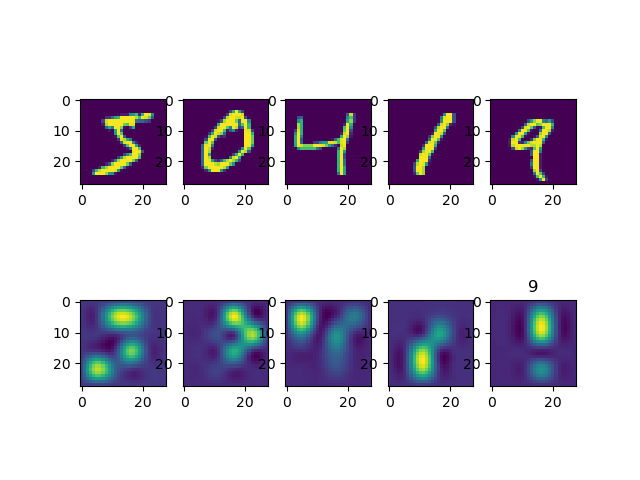

Net CNN_one_layer Epoch :  1 	 loss : 0.691199091461341 accuracy : 71.30142
Net CNN_one_layer Epoch :  2 	 loss : 0.863210062599496 accuracy : 73.06171
Net CNN_one_layer Epoch :  3 	 loss : 0.5759710963267652 accuracy : 74.09019
Net CNN_one_layer Epoch :  4 	 loss : 0.6661325906158151 accuracy : 75.31645
Net CNN Epoch :  1 	 loss : 0.4285772914104504 accuracy : 91.455696
Net CNN Epoch :  2 	 loss : 1.003487824496205 accuracy : 91.95016
Net CNN Epoch :  3 	 loss : 0.04671944884180822 accuracy : 92.80064
Net CNN Epoch :  4 	 loss : 0.1950695281249257 accuracy : 93.09731
Net RNN_Net Epoch :  1 	 loss : 0.0306191320334481 accuracy : 90.92168
Net RNN_Net Epoch :  2 	 loss : 0.3725702348202254 accuracy : 91.79193
Net RNN_Net Epoch :  3 	 loss : 0.622756292158728 accuracy : 92.44462
Net RNN_Net Epoch :  4 	 loss : 0.8045366141649943 accuracy : 92.68196


<IPython.core.display.Javascript object>


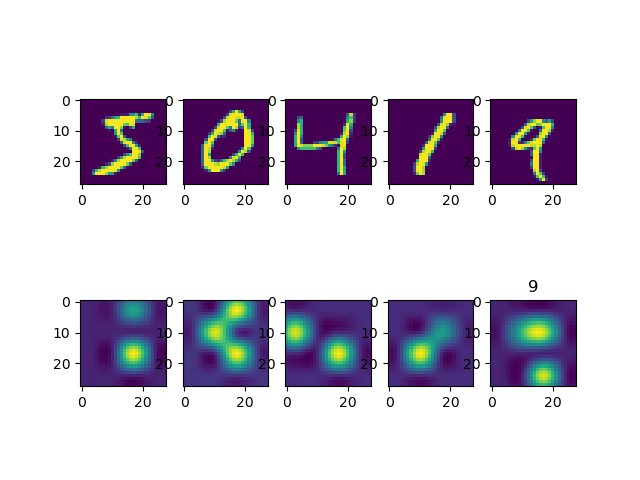

Net CNN_one_layer Epoch :  1 	 loss : 1.091285147429546 accuracy : 55.953323
Net CNN_one_layer Epoch :  2 	 loss : 1.3637322455591463 accuracy : 56.26978
Net CNN_one_layer Epoch :  3 	 loss : 1.0241632825066016 accuracy : 57.69383
Net CNN_one_layer Epoch :  4 	 loss : 1.2574200807986153 accuracy : 57.733387
Net CNN Epoch :  1 	 loss : 0.3563687918378178 accuracy : 85.36392
Net CNN Epoch :  2 	 loss : 0.1001856704725958 accuracy : 87.14399
Net CNN Epoch :  3 	 loss : 0.18602519021617958 accuracy : 88.09335
Net CNN Epoch :  4 	 loss : 0.06939883854482087 accuracy : 88.70649
Net RNN_Net Epoch :  1 	 loss : 0.8981230730889997 accuracy : 84.375
Net RNN_Net Epoch :  2 	 loss : 0.055121685428358505 accuracy : 86.59019
Net RNN_Net Epoch :  3 	 loss : 0.2611437356003775 accuracy : 87.14399
Net RNN_Net Epoch :  4 	 loss : 1.4014790532039272 accuracy : 86.55064


<IPython.core.display.Javascript object>


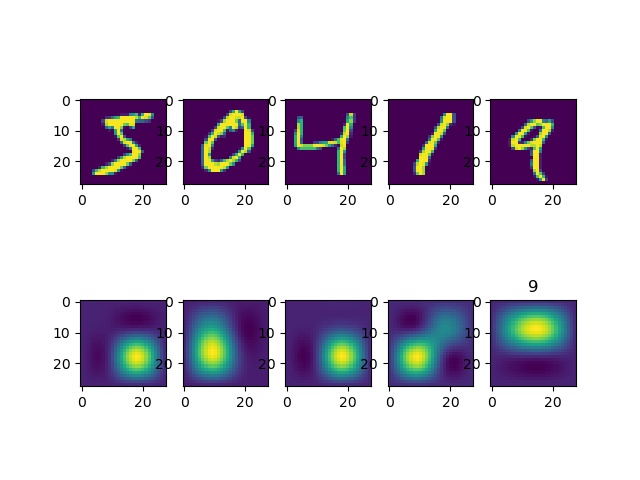

Net CNN_one_layer Epoch :  1 	 loss : 1.5466025119532458 accuracy : 45.134495
Net CNN_one_layer Epoch :  2 	 loss : 2.0142220650909826 accuracy : 46.795887
Net CNN_one_layer Epoch :  3 	 loss : 2.0044289221026075 accuracy : 47.92326
Net CNN_one_layer Epoch :  4 	 loss : 1.8117849737710008 accuracy : 49.545094
Net CNN Epoch :  1 	 loss : 0.25389401747419316 accuracy : 77.59098
Net CNN Epoch :  2 	 loss : 0.3315928847683092 accuracy : 80.419304
Net CNN Epoch :  3 	 loss : 0.5588076757955968 accuracy : 81.07199
Net CNN Epoch :  4 	 loss : 0.4679394264026527 accuracy : 81.66535
Net RNN_Net Epoch :  1 	 loss : 0.40406774143679897 accuracy : 77.116295
Net RNN_Net Epoch :  2 	 loss : 0.5312843431742397 accuracy : 80.557755
Net RNN_Net Epoch :  3 	 loss : 0.2942701764823667 accuracy : 81.981804
Net RNN_Net Epoch :  4 	 loss : 0.5336749465157996 accuracy : 82.970726


<IPython.core.display.Javascript object>


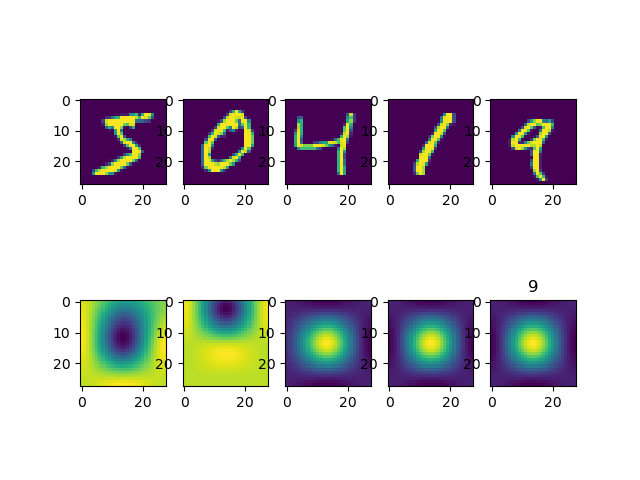

Net CNN_one_layer Epoch :  1 	 loss : 1.5252974610472059 accuracy : 41.732594
Net CNN_one_layer Epoch :  2 	 loss : 2.1813321662692764 accuracy : 41.198574
Net CNN_one_layer Epoch :  3 	 loss : 1.3541151588976807 accuracy : 43.23576
Net CNN_one_layer Epoch :  4 	 loss : 1.3671351545738477 accuracy : 45.68829
Net CNN Epoch :  1 	 loss : 0.30813998280291177 accuracy : 70.98497
Net CNN Epoch :  2 	 loss : 0.7535264702262678 accuracy : 72.883705
Net CNN Epoch :  3 	 loss : 0.4902171954872888 accuracy : 75.17801
Net CNN Epoch :  4 	 loss : 2.373503606204875 accuracy : 76.008705
Net RNN_Net Epoch :  1 	 loss : 1.0227074200248614 accuracy : 73.25949
Net RNN_Net Epoch :  2 	 loss : 1.4552156666869451 accuracy : 76.52294
Net RNN_Net Epoch :  3 	 loss : 0.5263197514485761 accuracy : 78.678795
Net RNN_Net Epoch :  4 	 loss : 1.189462121172934 accuracy : 78.79747


<IPython.core.display.Javascript object>


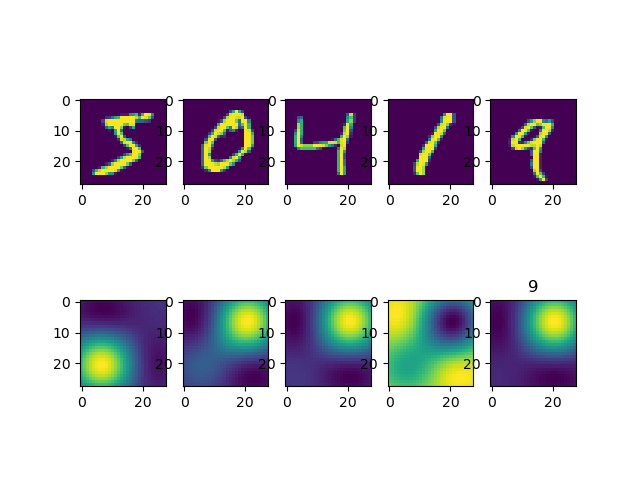

Net CNN_one_layer Epoch :  1 	 loss : 2.047512198639446 accuracy : 31.408228
Net CNN_one_layer Epoch :  2 	 loss : 1.2929457852165809 accuracy : 32.970726
Net CNN_one_layer Epoch :  3 	 loss : 2.132467330692657 accuracy : 33.84098
Net CNN_one_layer Epoch :  4 	 loss : 2.0162614600611697 accuracy : 33.8212
Net CNN Epoch :  1 	 loss : 0.8119789206819148 accuracy : 66.04035
Net CNN Epoch :  2 	 loss : 1.1512165147017348 accuracy : 68.53244
Net CNN Epoch :  3 	 loss : 0.693255875692157 accuracy : 69.71915
Net CNN Epoch :  4 	 loss : 1.8524681192768122 accuracy : 69.77848
Net RNN_Net Epoch :  1 	 loss : 1.5695500279204369 accuracy : 67.58307
Net RNN_Net Epoch :  2 	 loss : 0.940598840875145 accuracy : 71.004745
Net RNN_Net Epoch :  3 	 loss : 0.5895833939265682 accuracy : 73.35838
Net RNN_Net Epoch :  4 	 loss : 0.8488091408209095 accuracy : 73.239716


<IPython.core.display.Javascript object>


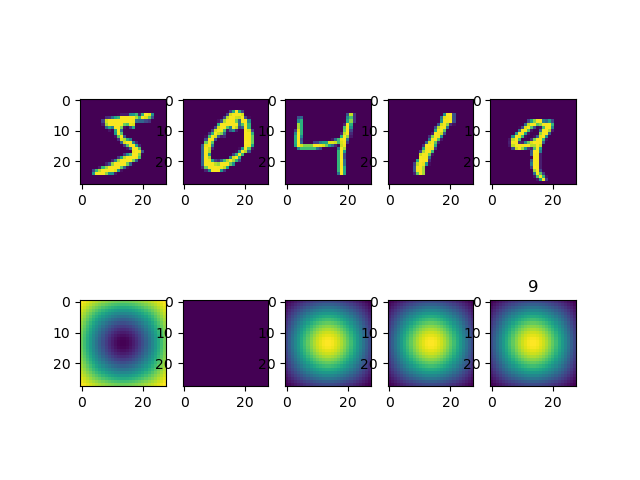

Net CNN_one_layer Epoch :  1 	 loss : 2.621620062083272 accuracy : 24.426424
Net CNN_one_layer Epoch :  2 	 loss : 2.234993369335291 accuracy : 25.25712
Net CNN_one_layer Epoch :  3 	 loss : 2.5882548019824076 accuracy : 25.25712
Net CNN_one_layer Epoch :  4 	 loss : 1.8278740629630095 accuracy : 26.30538
Net CNN Epoch :  1 	 loss : 1.56056359135799 accuracy : 54.628166
Net CNN Epoch :  2 	 loss : 1.286532705920572 accuracy : 56.071995
Net CNN Epoch :  3 	 loss : 1.5680349426872453 accuracy : 58.030064
Net CNN Epoch :  4 	 loss : 1.601511823935414 accuracy : 59.117878
Net RNN_Net Epoch :  1 	 loss : 0.8600760534596066 accuracy : 61.095726
Net RNN_Net Epoch :  2 	 loss : 1.0322344773108287 accuracy : 64.10206
Net RNN_Net Epoch :  3 	 loss : 0.6824783058948348 accuracy : 64.83386
Net RNN_Net Epoch :  4 	 loss : 0.42409594301922854 accuracy : 64.616295


<IPython.core.display.Javascript object>


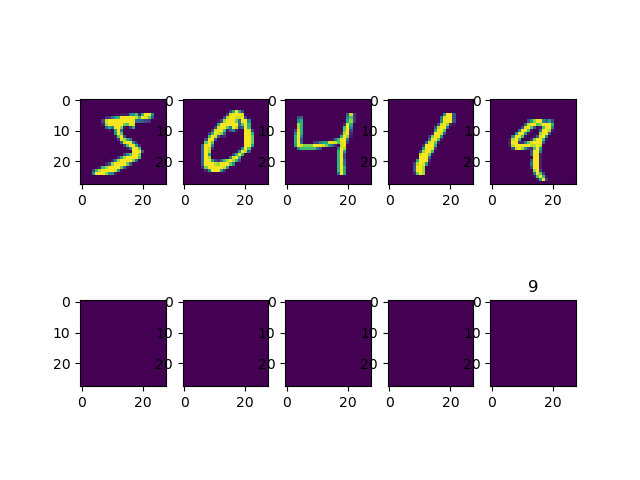

Net CNN_one_layer Epoch :  1 	 loss : 2.313385885487084 accuracy : 10.4825945
Net CNN_one_layer Epoch :  2 	 loss : 2.2929106061953157 accuracy : 10.621044
Net CNN_one_layer Epoch :  3 	 loss : 2.3050225664852695 accuracy : 10.4825945
Net CNN_one_layer Epoch :  4 	 loss : 2.30478540807447 accuracy : 10.4825945
Net CNN Epoch :  1 	 loss : 2.308220970496427 accuracy : 11.3924055
Net CNN Epoch :  2 	 loss : 2.30975807742232 accuracy : 10.9770565
Net CNN Epoch :  3 	 loss : 2.2870259918449722 accuracy : 11.669304
Net CNN Epoch :  4 	 loss : 2.3070249470012296 accuracy : 11.352848
Net RNN_Net Epoch :  1 	 loss : 2.1064773961932204 accuracy : 10.759494
Net RNN_Net Epoch :  2 	 loss : 2.3376458732769443 accuracy : 12.005538
Net RNN_Net Epoch :  3 	 loss : 2.2555024757131767 accuracy : 11.550632
Net RNN_Net Epoch :  4 	 loss : 2.207886800934025 accuracy : 12.005538


In [12]:
res_list = [10,8,6,5,4,3,2]
cnn_one_image = []
cnn_lasagna = []
cnn_rnn = []
cnn_one_image_train_loss = []
cnn_lasagna_train_loss = []
cnn_rnn_train_loss = []
for res in res_list:
    #Load the training data
    train_dataloader, test_dataloader, _, _ = create_dataset(images, labels,res = res)
    #Run the CNN over one image only
    cnn1_train_loss, cnn1_test_loss, cnn1_test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 4)
    cnn_one_image.append(cnn1_test_accur[-1])
    cnn_one_image_train_loss.append(cnn1_train_loss[-1])
    #Run the CNN over the stacked images
    cnn_train_loss, cnn_test_loss, cnn_test_accur =  train(train_dataloader, test_dataloader,net = CNN(traject = True).double(), epochs = 4)
    cnn_lasagna.append(cnn_test_accur[-1])
    cnn_lasagna_train_loss.append(cnn_train_loss[-1])
    #Run the CNN+RNN over the stacked images
    rnn_train_loss, rnn_test_loss, rnn_test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 4)
    cnn_rnn.append(rnn_test_accur[-1])
    cnn_rnn_train_loss.append(rnn_train_loss[-1])

<IPython.core.display.Javascript object>


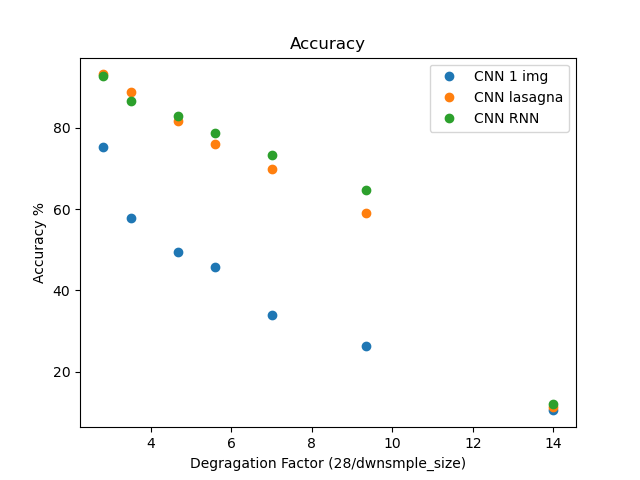

<IPython.core.display.Javascript object>


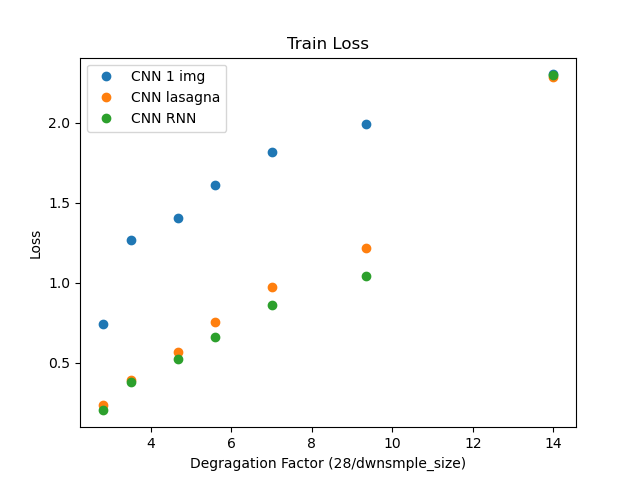

In [19]:
plt.figure()
plt.plot(28/np.array(res_list),cnn_one_image,'o', label = 'CNN 1 img')
plt.plot(28/np.array(res_list),cnn_lasagna,'o', label = 'CNN lasagna')
plt.plot(28/np.array(res_list),cnn_rnn,'o', label = 'CNN RNN')
plt.title('Accuracy')
plt.xlabel('Degragation Factor (28/dwnsmple_size)')
plt.ylabel('Accuracy %')
plt.legend()

plt.figure()
plt.plot(28/np.array(res_list),cnn_one_image_train_loss,'o', label = 'CNN 1 img')
plt.plot(28/np.array(res_list),cnn_lasagna_train_loss, 'o',label = 'CNN lasagna')
plt.plot(28/np.array(res_list),cnn_rnn_train_loss, 'o',label = 'CNN RNN')
plt.title('Train Loss')
plt.xlabel('Degragation Factor (28/dwnsmple_size)')
plt.ylabel('Loss')
plt.legend()

<IPython.core.display.Javascript object>


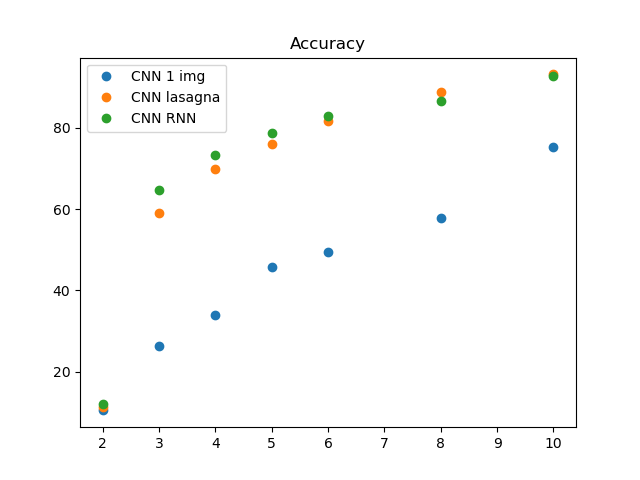

<IPython.core.display.Javascript object>


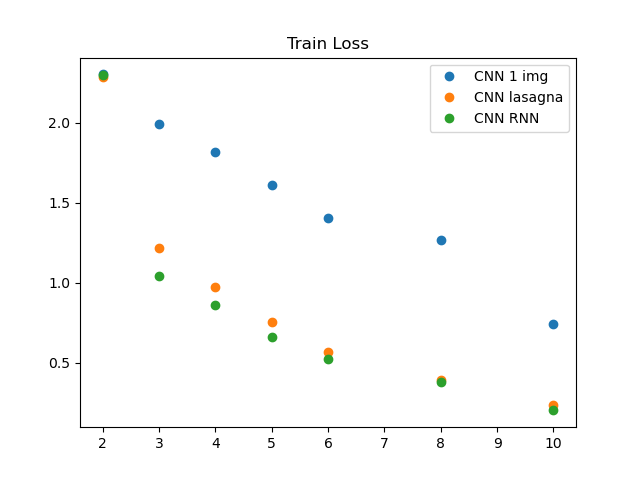

In [17]:
plt.figure()
plt.plot(np.array(res_list),cnn_one_image,'o', label = 'CNN 1 img')
plt.plot(np.array(res_list),cnn_lasagna,'o', label = 'CNN lasagna')
plt.plot(np.array(res_list),cnn_rnn,'o', label = 'CNN RNN')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(np.array(res_list),cnn_one_image_train_loss,'o', label = 'CNN 1 img')
plt.plot(np.array(res_list),cnn_lasagna_train_loss, 'o',label = 'CNN lasagna')
plt.plot(np.array(res_list),cnn_rnn_train_loss, 'o',label = 'CNN RNN')
plt.title('Train Loss')
plt.legend()